In [1]:
1*2

2

In [2]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
|  2 |  0% |  0% |
|  3 |  0% |  0% |
|  4 |  0% |  0% |
|  5 |  0% |  0% |
|  6 |  0% |  0% |
|  7 |  0% |  0% |


In [6]:
import importlib
def rl(module):
    importlib.reload(module)

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import gpytorch

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

# import Di

In [5]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
output_device = 0
n_devices = torch.cuda.device_count()

8
0


### kernel module

In [6]:
from gpytorch import settings
from gpytorch.constraints import Positive
from gpytorch.lazy import LazyEvaluatedKernelTensor, ZeroLazyTensor, delazify, lazify
from gpytorch.models import exact_prediction_strategies
from gpytorch.module import Module
from gpytorch.utils.broadcasting import _mul_broadcast_shape

In [7]:
#!/usr/bin/env python3

import warnings
from abc import abstractmethod
from copy import deepcopy

import torch
from torch.nn import ModuleList

from gpytorch import settings
from gpytorch.constraints import Positive
from gpytorch.lazy import LazyEvaluatedKernelTensor, ZeroLazyTensor, delazify, lazify
from gpytorch.models import exact_prediction_strategies
from gpytorch.module import Module
from gpytorch.utils.broadcasting import _mul_broadcast_shape


def default_postprocess_script(x):
    return x

In [8]:
def d(geno1, geno2):
  """build distance tensor between two sets of genotypes
  geno1, geno2: n x L, m x L torch tensors

  """
  geno1_h0 = 1. * (geno1 == 0.)
  geno1_h1 = 1. * (geno1 == 2.)
  geno2_h0 = 1. * (geno2 == 0.)
  geno2_h1 = 1. * (geno2 == 2.)
  S1 = torch.matmul(geno1 % 2, torch.transpose(geno2 % 2, 0, 1))
  S2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h0, 0, 1))
        + torch.matmul(geno1_h1, torch.transpose(geno2_h1, 0, 1)))
  D2 = (torch.matmul(geno1_h0, torch.transpose(geno2_h1, 0, 1))
        + torch.matmul(geno1_h1, torch.transpose(geno2_h0, 0, 1)))
  D1 = L - S1 - S2 - D2

  return torch.stack((S1, S2, D1, D2))

In [9]:
class Distance1(torch.nn.Module):
    def __init__(self, postprocess_script=default_postprocess_script):
        super().__init__()
        self._postprocess = postprocess_script

    def _sq_dist(self, x1, x2, postprocess, x1_eq_x2=False):
        # TODO: use torch squared cdist once implemented: https://github.com/pytorch/pytorch/pull/25799
#         adjustment = x1.mean(-2, keepdim=True)
#         x1 = x1 - adjustment
#         x2 = x2 - adjustment  # x1 and x2 should be identical in all dims except -2 at this point

        # Compute squared distance matrix using quadratic expansion
#         x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
#         x1_pad = torch.ones_like(x1_norm)
#         if x1_eq_x2 and not x1.requires_grad and not x2.requires_grad:
#             x2_norm, x2_pad = x1_norm, x1_pad
#         else:
#             x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
#             x2_pad = torch.ones_like(x2_norm)
#         x1_ = torch.cat([-2.0 * x1, x1_norm, x1_pad], dim=-1)
#         x2_ = torch.cat([x2, x2_pad, x2_norm], dim=-1)
#         res = x1_.matmul(x2_.transpose(-2, -1))
        res = x1.matmul(x2.transpose(-2, -1))        

        if x1_eq_x2 and not x1.requires_grad and not x2.requires_grad:
            pass
#             res.diagonal(dim1=-2, dim2=-1).fill_(0)

        # Zero out negative values
        res.clamp_min_(0)
        return self._postprocess(res) if postprocess else res

    def _dist(self, x1, x2, postprocess, x1_eq_x2=False):
        # TODO: use torch cdist once implementation is improved: https://github.com/pytorch/pytorch/pull/25799
        res = self._sq_dist(x1, x2, postprocess=False, x1_eq_x2=x1_eq_x2)
        res = res.clamp_min_(1e-30).sqrt_()
        return self._postprocess(res) if postprocess else res


In [10]:
class Kernel(Module):

    has_lengthscale = False

    def __init__(
        self,
        ard_num_dims=None,
        batch_shape=torch.Size([]),
        active_dims=None,
        lengthscale_prior=None,
        lengthscale_constraint=None,
        eps=1e-6,
        **kwargs,
    ):
        super(Kernel, self).__init__()
        self._batch_shape = batch_shape
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.register_buffer("active_dims", active_dims)
        self.ard_num_dims = ard_num_dims

        self.eps = eps

        param_transform = kwargs.get("param_transform")

        if lengthscale_constraint is None:
            lengthscale_constraint = Positive()

        if param_transform is not None:
            warnings.warn(
                "The 'param_transform' argument is now deprecated. If you want to use a different "
                "transformation, specify a different 'lengthscale_constraint' instead.",
                DeprecationWarning,
            )

        if self.has_lengthscale:
            lengthscale_num_dims = 1 if ard_num_dims is None else ard_num_dims
            self.register_parameter(
                name="raw_lengthscale",
                parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, lengthscale_num_dims)),
            )
            if lengthscale_prior is not None:
                self.register_prior(
                    "lengthscale_prior", lengthscale_prior, lambda m: m.lengthscale, lambda m, v: m._set_lengthscale(v)
                )

            self.register_constraint("raw_lengthscale", lengthscale_constraint)

        self.distance_module = None
        # TODO: Remove this on next official PyTorch release.
        self.__pdist_supports_batch = True

    @abstractmethod
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        raise NotImplementedError()

    @property
    def batch_shape(self):
        kernels = list(self.sub_kernels())
        if len(kernels):
            return _mul_broadcast_shape(self._batch_shape, *[k.batch_shape for k in kernels])
        else:
            return self._batch_shape

    @batch_shape.setter
    def batch_shape(self, val):
        self._batch_shape = val

    @property
    def dtype(self):
        if self.has_lengthscale:
            return self.lengthscale.dtype
        else:
            for param in self.parameters():
                return param.dtype
            return torch.get_default_dtype()

    @property
    def is_stationary(self) -> bool:
        """
        Property to indicate whether kernel is stationary or not.
        """
        return self.has_lengthscale

    @property
    def lengthscale(self):
        if self.has_lengthscale:
            return self.raw_lengthscale_constraint.transform(self.raw_lengthscale)
        else:
            return None

    @lengthscale.setter
    def lengthscale(self, value):
        self._set_lengthscale(value)

    def _set_lengthscale(self, value):
        if not self.has_lengthscale:
            raise RuntimeError("Kernel has no lengthscale.")

        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengthscale)

        self.initialize(raw_lengthscale=self.raw_lengthscale_constraint.inverse_transform(value))

    def local_load_samples(self, samples_dict, memo, prefix):
        num_samples = next(iter(samples_dict.values())).size(0)
        self.batch_shape = torch.Size([num_samples]) + self.batch_shape
        super().local_load_samples(samples_dict, memo, prefix)

    def covar_dist(
        self,
        x1,
        x2,
        diag=False,
        last_dim_is_batch=False,
        square_dist=True,
        dist_postprocess_func=default_postprocess_script,
        postprocess=True,
        **params,
    ):

        if last_dim_is_batch:
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)

        # torch scripts expect tensors
        postprocess = torch.tensor(postprocess)

        res = None

        # Cache the Distance object or else JIT will recompile every time
        if not self.distance_module or self.distance_module._postprocess != dist_postprocess_func:
            self.distance_module = Distance1(dist_postprocess_func)

        if diag:
            # Special case the diagonal because we can return all zeros most of the time.
            if x1_eq_x2:
                res = torch.zeros(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                if postprocess:
                    res = dist_postprocess_func(res)
                return res
            else:
                res = torch.norm(x1 - x2, p=2, dim=-1)
                if square_dist:
                    res = res.pow(2)
            if postprocess:
                res = dist_postprocess_func(res)
            return res

        elif square_dist:
            res = self.distance_module._sq_dist(x1, x2, postprocess, x1_eq_x2)
        else:
            res = self.distance_module._dist(x1, x2, postprocess, x1_eq_x2)

        return res

    def named_sub_kernels(self):
        for name, module in self.named_modules():
            if module is not self and isinstance(module, Kernel):
                yield name, module

    def num_outputs_per_input(self, x1, x2):
        """
        How many outputs are produced per input (default 1)
        if x1 is size `n x d` and x2 is size `m x d`, then the size of the kernel
        will be `(n * num_outputs_per_input) x (m * num_outputs_per_input)`
        Default: 1
        """
        return 1

    def prediction_strategy(self, train_inputs, train_prior_dist, train_labels, likelihood):
        return exact_prediction_strategies.DefaultPredictionStrategy(
            train_inputs, train_prior_dist, train_labels, likelihood
        )

    def sub_kernels(self):
        for _, kernel in self.named_sub_kernels():
            yield kernel

    def __call__(self, x1, x2=None, diag=False, last_dim_is_batch=False, **params):
        x1_, x2_ = x1, x2

        # Select the active dimensions
        if self.active_dims is not None:
            x1_ = x1_.index_select(-1, self.active_dims)
            if x2_ is not None:
                x2_ = x2_.index_select(-1, self.active_dims)

        # Give x1_ and x2_ a last dimension, if necessary
        if x1_.ndimension() == 1:
            x1_ = x1_.unsqueeze(1)
        if x2_ is not None:
            if x2_.ndimension() == 1:
                x2_ = x2_.unsqueeze(1)
            if not x1_.size(-1) == x2_.size(-1):
                raise RuntimeError("x1_ and x2_ must have the same number of dimensions!")

        if x2_ is None:
            x2_ = x1_

        # Check that ard_num_dims matches the supplied number of dimensions
        if settings.debug.on():
            if self.ard_num_dims is not None and self.ard_num_dims != x1_.size(-1):
                raise RuntimeError(
                    "Expected the input to have {} dimensionality "
                    "(based on the ard_num_dims argument). Got {}.".format(self.ard_num_dims, x1_.size(-1))
                )

        if diag:
            res = super(Kernel, self).__call__(x1_, x2_, diag=True, last_dim_is_batch=last_dim_is_batch, **params)
            # Did this Kernel eat the diag option?
            # If it does not return a LazyEvaluatedKernelTensor, we can call diag on the output
            if not isinstance(res, LazyEvaluatedKernelTensor):
                if res.dim() == x1_.dim() and res.shape[-2:] == torch.Size((x1_.size(-2), x2_.size(-2))):
                    res = res.diag()
            return res

        else:
            if settings.lazily_evaluate_kernels.on():
                res = LazyEvaluatedKernelTensor(x1_, x2_, kernel=self, last_dim_is_batch=last_dim_is_batch, **params)
            else:
                res = lazify(super(Kernel, self).__call__(x1_, x2_, last_dim_is_batch=last_dim_is_batch, **params))
            return res

    def __getstate__(self):
        # JIT ScriptModules cannot be pickled
        self.distance_module = None
        return self.__dict__

    def __add__(self, other):
        kernels = []
        kernels += self.kernels if isinstance(self, AdditiveKernel) else [self]
        kernels += other.kernels if isinstance(other, AdditiveKernel) else [other]
        return AdditiveKernel(*kernels)

    def __mul__(self, other):
        kernels = []
        kernels += self.kernels if isinstance(self, ProductKernel) else [self]
        kernels += other.kernels if isinstance(other, ProductKernel) else [other]
        return ProductKernel(*kernels)

    def __setstate__(self, d):
        self.__dict__ = d

    def __getitem__(self, index):
        if len(self.batch_shape) == 0:
            return self

        new_kernel = deepcopy(self)
        # Process the index
        index = index if isinstance(index, tuple) else (index,)

        for param_name, param in self._parameters.items():
            new_kernel._parameters[param_name].data = param.__getitem__(index)
            ndim_removed = len(param.shape) - len(new_kernel._parameters[param_name].shape)
            new_batch_shape_len = len(self.batch_shape) - ndim_removed
            new_kernel.batch_shape = new_kernel._parameters[param_name].shape[:new_batch_shape_len]

        for sub_module_name, sub_module in self.named_sub_kernels():
            self._modules[sub_module_name] = sub_module.__getitem__(index)

        return new_kernel


class AdditiveKernel(Kernel):
    """
    A Kernel that supports summing over multiple component kernels.

    Example:
        >>> covar_module = RBFKernel(active_dims=torch.tensor([1])) + RBFKernel(active_dims=torch.tensor([2]))
        >>> x1 = torch.randn(50, 2)
        >>> additive_kernel_matrix = covar_module(x1)
    """

    @property
    def is_stationary(self) -> bool:
        """
        Kernel is stationary if all components are stationary.
        """
        return all(k.is_stationary for k in self.kernels)

    def __init__(self, *kernels):
        super(AdditiveKernel, self).__init__()
        self.kernels = ModuleList(kernels)

    def forward(self, x1, x2, diag=False, **params):
        res = ZeroLazyTensor() if not diag else 0
        for kern in self.kernels:
            next_term = kern(x1, x2, diag=diag, **params)
            if not diag:
                res = res + lazify(next_term)
            else:
                res = res + next_term

        return res

    def num_outputs_per_input(self, x1, x2):
        return self.kernels[0].num_outputs_per_input(x1, x2)

    def __getitem__(self, index):
        new_kernel = deepcopy(self)
        for i, kernel in enumerate(self.kernels):
            new_kernel.kernels[i] = self.kernels[i].__getitem__(index)

        return new_kernel


class ProductKernel(Kernel):
    """
    A Kernel that supports elementwise multiplying multiple component kernels together.

    Example:
        >>> covar_module = RBFKernel(active_dims=torch.tensor([1])) * RBFKernel(active_dims=torch.tensor([2]))
        >>> x1 = torch.randn(50, 2)
        >>> kernel_matrix = covar_module(x1) # The RBF Kernel already decomposes multiplicatively, so this is foolish!
    """

    @property
    def is_stationary(self) -> bool:
        """
        Kernel is stationary if all components are stationary.
        """
        return all(k.is_stationary for k in self.kernels)

    def __init__(self, *kernels):
        super(ProductKernel, self).__init__()
        self.kernels = ModuleList(kernels)

    def forward(self, x1, x2, diag=False, **params):
        x1_eq_x2 = torch.equal(x1, x2)

        if not x1_eq_x2:
            # If x1 != x2, then we can't make a MulLazyTensor because the kernel won't necessarily be square/symmetric
            res = delazify(self.kernels[0](x1, x2, diag=diag, **params))
        else:
            res = self.kernels[0](x1, x2, diag=diag, **params)

            if not diag:
                res = lazify(res)

        for kern in self.kernels[1:]:
            next_term = kern(x1, x2, diag=diag, **params)
            if not x1_eq_x2:
                # Again delazify if x1 != x2
                res = res * delazify(next_term)
            else:
                if not diag:
                    res = res * lazify(next_term)
                else:
                    res = res * next_term

        return res

    def num_outputs_per_input(self, x1, x2):
        return self.kernels[0].num_outputs_per_input(x1, x2)

    def __getitem__(self, index):
        new_kernel = deepcopy(self)
        for i, kernel in enumerate(self.kernels):
            new_kernel.kernels[i] = self.kernels[i].__getitem__(index)

        return new_kernel

In [11]:
def di_k(log_lda, log_eta, S1, S2, D2):
    
    lda = torch.exp(log_lda)
    eta = torch.exp(log_eta)
    
    k = (((1 + lda + eta)**(S2 - L/2))
    *((1 - lda + eta)**D2)
    *((1 + eta)**(S1 - L/2)) 
    * (1 - eta)**((L - S1 - S2 - D2)))
    
    return k


from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class DiKernel(Kernel):
    """Diploid kernel"""

    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, 
                lda_prior=None, lda_constraint=None, 
                eta_prior=None, eta_constraint=None,
                **kwargs):
      super().__init__(**kwargs)

      # register the raw parameter
      self.register_parameter(
          name='raw_lda', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      self.register_parameter(
          name='raw_eta', 
          parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
      )

      # set the parameter constraint to be positive, when nothing is specified
      if lda_constraint is None:
          lda_constraint = LessThan(upper_bound=0.)

      if eta_constraint is None:
          eta_constraint = LessThan(upper_bound=0.)

      # register the constraint
      self.register_constraint("raw_lda", lda_constraint)
      self.register_constraint("raw_eta", eta_constraint)


    # now set up the 'actual' paramter
    @property
    def lda(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_lda_constraint.transform(self.raw_lda)

    @property
    def eta(self):
      # when accessing the parameter, apply the constraint transform
      return self.raw_eta_constraint.transform(self.raw_eta)

    @lda.setter
    def lda(self, value):
      return self._set_lda(value)

    @eta.setter
    def eta(self, value):
      return self._set_eta(value)

    def forward(self, geno1, geno2, **params):
        geno1_ht = 1.*(geno1 == 1.)
        geno2_ht = 1.*(geno2 == 1.)        
        geno1_h0 = 1.*(geno1 == 0.)
        geno1_h1 = 1.*(geno1 == 2.)
        geno2_h0 = 1.*(geno2 == 0.)
        geno2_h1 = 1.*(geno2 == 2.)

        S1 = self.covar_dist(geno1_ht, geno2_ht, **params)
        S2 = self.covar_dist(geno1_h0, geno2_h0, **params) + self.covar_dist(geno1_h1, geno2_h1, **params)
        D2 = self.covar_dist(geno1_h0, geno2_h1, **params) + self.covar_dist(geno1_h1, geno2_h0, **params)

#         res = torch.exp(-.01*S1)*torch.exp(-.05*S2)*torch.exp(-.02*D2)*torch.exp(-.001*(L - S1 - S2 - D2))
#         return res

        return di_k(self.lda, self.eta, S1, S2, D2)

In [12]:
def rbf_k(length, S1, S2, D2):
    D1 = L - S1 - S2 - D2
    diff = (D1 + 4*D2)/L
    return torch.exp(-length*diff)

class RBFKernel(Kernel):
    is_stationary = True

    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)        

        # register the raw parameter
        self.register_parameter(
            name='raw_length', 
            parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        length_constraint = Positive()
            

        # register the constraint
        self.register_constraint("raw_length", length_constraint)


    # set up actual paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

        
#     def forward(self, geno1, geno2, **params):
#         geno1_h0 = 1.*(geno1 == 0.)
#         geno1_h1 = 1.*(geno1 == 2.)
#         geno2_h0 = 1.*(geno2 == 0.)
#         geno2_h1 = 1.*(geno2 == 2.)

#         S1 = self.covar_dist(geno1, geno2, **params)
#         S2 = self.covar_dist(geno1_h0, geno2_h0, **params) + self.covar_dist(geno1_h1, geno2_h1, **params)
#         D2 = self.covar_dist(geno1_h0, geno2_h1, **params) + self.covar_dist(geno1_h1, geno2_h0, **params)

# #         res = torch.exp(-.01*S1)*torch.exp(-.05*S2)*torch.exp(-.02*D2)*torch.exp(-.001*(L - S1 - S2 - D2))
# #         return res

#         return rbf_k(self.length, S1, S2, D2)

#     def calc_d(self, geno1, geno2, **params):
#         geno1_ht = 1.*(geno1 == 1.)
#         geno2_ht = 1.*(geno2 == 1.)
#         geno1_h0 = 1.*(geno1 == 0.)
#         geno1_h1 = 1.*(geno1 == 2.)
#         geno2_h0 = 1.*(geno2 == 0.)
#         geno2_h1 = 1.*(geno2 == 2.)

#         S1 = self.covar_dist(geno1_ht, geno2_ht, **params)
#         S2 = self.covar_dist(geno1_h0, geno2_h0, **params) + self.covar_dist(geno1_h1, geno2_h1, **params)
#         D2 = self.covar_dist(geno1_h0, geno2_h1, **params) + self.covar_dist(geno1_h1, geno2_h0, **params)
#         D1 = L - S1 - S2 - D2
#         diff = (D1 + 4*D2)/L
#         return S1, S2, D2

#     def forward(self, geno1, geno2, diag=False, **params):
#         geno1_ht = 1.*(geno1 == 1.)
#         geno2_ht = 1.*(geno2 == 1.)
#         geno1_h0 = 1.*(geno1 == 0.)
#         geno1_h1 = 1.*(geno1 == 2.)
#         geno2_h0 = 1.*(geno2 == 0.)
#         geno2_h1 = 1.*(geno2 == 2.)

#         S1 = self.covar_dist(geno1_ht, geno2_ht, **params)
#         S2 = self.covar_dist(geno1_h0, geno2_h0, **params) + self.covar_dist(geno1_h1, geno2_h1, **params)
#         D2 = self.covar_dist(geno1_h0, geno2_h1, **params) + self.covar_dist(geno1_h1, geno2_h0, **params)
        
#         return rbf_k(self.length, S1, S2, D2)

    def forward(self, geno1, geno2, diag=False, **params):
        geno1_ht = 1.*(geno1 == 1.)
        geno2_ht = 1.*(geno2 == 1.)
        geno1_h0 = 1.*(geno1 == 0.)
        geno1_h1 = 1.*(geno1 == 2.)
        geno2_h0 = 1.*(geno2 == 0.)
        geno2_h1 = 1.*(geno2 == 2.)

        S1 = self.covar_dist(geno1_ht, geno2_ht, **params)
        S2 = self.covar_dist(geno1_h0, geno2_h0, **params) + self.covar_dist(geno1_h1, geno2_h1, **params)
        D2 = self.covar_dist(geno1_h0, geno2_h1, **params) + self.covar_dist(geno1_h1, geno2_h0, **params)
        D1 = L - S1 - S2 - D2
        diff = (D1 + 4*D2)/L

        return torch.exp(-diff)
    

In [13]:
class DiGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(DiGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = DiKernel()

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices, ker):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = ker

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
rl(Kernels)

In [11]:
import Kernels

In [13]:
from Kernels import get_envs

In [17]:
env_list = get_envs()
env = env_list[5]

In [15]:
geno_file_list = []
for path, currentDirectory, files in os.walk("96ghpptzvf-4/SData2/"):
    for file in files:
        if file.endswith("geno.txt"):
            geno_file_list.append(file)

geno_file_list = list(set(geno_file_list))

env_list = [file.split('_')[0] for file in geno_file_list]
env_list = sorted(env_list)
env = env_list[5]

df = pd.read_csv("96ghpptzvf-4/SData2/"+ env + "_geno.txt", sep='\t', nrows=5, engine='python')
ids = list(df.columns[3:])

geno_t = torch.load(env + '_matsui_geno_t.pt')
geno_t = torch.tensor(geno_t, dtype=torch.float)
geno_t = torch.transpose(geno_t, 0, 1)
N, L = geno_t.shape

pheno = pd.read_csv("96ghpptzvf-4/SData6/" + env + "_pheno.txt", sep='\t', engine="python")
pheno = pheno.set_index('geno')
pheno = pheno.loc[ids]

/scratch/local/43122499/ipykernel_241665/2080791058.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  geno_t = torch.tensor(geno_t, dtype=torch.float)


In [1]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

np.random.seed(100)
sub = np.random.choice(inds_sub, 100000)
sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5000)

train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

NameError: name 'np' is not defined

In [ ]:
x1 = train_x[:10]
x2 = train_x[10:20]

### Control: Diploid kernel

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = DiGPModel(train_x, train_y, likelihood, n_devices)
model.covar_module.module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model = model.to(output_device)

In [ ]:
preconditioner_size = 100
checkpoint_size = train_x.shape[0]//8
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
    f_preds = model(test_x)

In [ ]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### Test on small training data

In [86]:
ker = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()).to(output_device)
ker = gpytorch.kernels.RBFKernel().to(output_device)

In [87]:
ker.state_dict()

OrderedDict([('raw_lengthscale', tensor([[0.]], device='cuda:0')),
             ('raw_lengthscale_constraint.lower_bound',
              tensor(0., device='cuda:0')),
             ('raw_lengthscale_constraint.upper_bound',
              tensor(inf, device='cuda:0'))])

In [88]:
ker.state_dict()

OrderedDict([('raw_lengthscale', tensor([[0.]], device='cuda:0')),
             ('raw_lengthscale_constraint.lower_bound',
              tensor(0., device='cuda:0')),
             ('raw_lengthscale_constraint.upper_bound',
              tensor(inf, device='cuda:0'))])

In [112]:
ls = torch.nn.Parameter(torch.tensor([[-5.]]))

In [113]:
ker.raw_lengthscale = ls
ker.to(output_device)

RBFKernel(
  (raw_lengthscale_constraint): Positive()
  (distance_module): Distance()
)

In [115]:
ker(x1/L, x1/L).evaluate()

tensor([[1.0000, 0.1925, 0.2045, 0.2168, 0.2200, 0.3206, 0.1962, 0.4119, 0.2367,
         0.2102],
        [0.1925, 1.0000, 0.1828, 0.2205, 0.1950, 0.1868, 0.1498, 0.2436, 0.1656,
         0.1639],
        [0.2045, 0.1828, 1.0000, 0.2770, 0.2547, 0.1838, 0.1995, 0.2809, 0.2593,
         0.1969],
        [0.2168, 0.2205, 0.2770, 1.0000, 0.1778, 0.2399, 0.2188, 0.2370, 0.3215,
         0.2401],
        [0.2200, 0.1950, 0.2547, 0.1778, 1.0000, 0.1604, 0.2465, 0.2726, 0.2545,
         0.2351],
        [0.3206, 0.1868, 0.1838, 0.2399, 0.1604, 1.0000, 0.1788, 0.3050, 0.2800,
         0.2470],
        [0.1962, 0.1498, 0.1995, 0.2188, 0.2465, 0.1788, 1.0000, 0.1754, 0.2470,
         0.2930],
        [0.4119, 0.2436, 0.2809, 0.2370, 0.2726, 0.3050, 0.1754, 1.0000, 0.2546,
         0.2505],
        [0.2367, 0.1656, 0.2593, 0.3215, 0.2545, 0.2800, 0.2470, 0.2546, 1.0000,
         0.2304],
        [0.2102, 0.1639, 0.1969, 0.2401, 0.2351, 0.2470, 0.2930, 0.2505, 0.2304,
         1.0000]], device='c

In [70]:
ker.covar_dist(x1, x2)

tensor([[ 89.4727,  95.0796,  99.3620,  95.3247,  90.1218,  91.1756,  87.7513,
          88.9931,  92.6157,  83.0506],
        [ 94.1384,  90.8895,  82.3053,  90.9739,  94.1842,  94.2860,  87.4397,
          89.1014,  95.5431,  98.0323],
        [ 88.5815,  84.0687,  85.7816,  82.3303,  89.8375,  84.9743,  86.9586,
          97.0815,  88.4477,  92.1336],
        [ 84.4071,  87.6890,  82.9835,  83.4276,  93.7049,  80.8839,  77.1340,
          77.9550,  83.8739,  88.0369],
        [ 80.4757,  88.5139,  86.0221,  84.8645,  90.0569,  86.9686,  93.5664,
          90.6443,  89.9461, 101.4487],
        [ 90.8344,  85.4283,  95.8678,  92.6740,  97.5362,  92.3388,  87.3040,
          89.4281,  93.2592,  88.9674],
        [ 81.7279,  87.9421,  93.7064,  91.6986, 106.9635,  93.8651,  91.7492,
          94.1675,  88.9465,  97.8207],
        [ 86.0479,  90.5384,  90.2665,  84.1662,  83.3121,  89.0627,  83.6023,
          87.9009,  91.4042,  82.1971],
        [ 82.2423,  87.2850,  85.3081,  87.4491,

In [73]:
Dmat = d(x1, x2)

In [74]:
Dmat[2] + 4*Dmat[3]

tensor([[ 8005.,  9040.,  9875.,  9089.,  8122.,  8312.,  7700.,  7921.,  8579.,
          6899.],
        [ 8862.,  8261.,  6776.,  8278.,  8871.,  8889.,  7645.,  7940.,  9130.,
          9612.],
        [ 7845.,  7066.,  7359.,  6779.,  8070.,  7218.,  7560.,  9425.,  7823.,
          8489.],
        [ 7123.,  7688.,  6887.,  6961.,  8780.,  6540.,  5948.,  6077.,  7035.,
          7751.],
        [ 6475.,  7834.,  7401.,  7203.,  8110.,  7562.,  8754.,  8217.,  8091.,
         10293.],
        [ 8250.,  7297.,  9192.,  8590.,  9513.,  8525.,  7621.,  7998.,  8698.,
          7916.],
        [ 6678.,  7733.,  8782.,  8410., 11441.,  8809.,  8417.,  8868.,  7912.,
          9570.],
        [ 7403.,  8196.,  8149.,  7085.,  6940.,  7930.,  6988.,  7727.,  8355.,
          6757.],
        [ 6763.,  7618.,  7279.,  7649.,  9814.,  7014.,  6056.,  6593.,  8369.,
          7371.],
        [ 7123.,  6516.,  9451.,  7187.,  9154.,  7602.,  7398.,  7777.,  7473.,
          8169.]], device='c

In [121]:
class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(RBFGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        base_covar_module = ker


        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [49]:
def train_model(model, 
                likelihood, 
                train_x, 
                train_y, 
                checkpoint_size, 
                preconditioner_size, 
                training_iter=300, 
                lr=.05):
    losses = []
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        print(i)
        with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()  
            losses.append(loss.item())
            optimizer.step()

In [54]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

np.random.seed(100)
sub = np.random.choice(inds_sub, 10000)
sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 5000)

train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [128]:
ls = torch.nn.Parameter(torch.tensor([[-5.]]))

In [179]:
ker = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()).to(output_device)
ker = gpytorch.kernels.RBFKernel().to(output_device)
ker.raw_lengthscale = ls
ker.to(output_device)

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)

In [207]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = RBFGPModel(train_x, train_y, likelihood, n_devices)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.AdamW(model.parameters(), .02)

In [208]:
model = model.to(output_device)

In [209]:
model.covar_module.module.lengthscale = torch.tensor([[100.]]).to(output_device)

In [210]:
checkpoint_size = train_x.shape[0]//8
checkpoint_size = 0
preconditioner_size = 100

In [211]:
losses = train_model(model, 
                likelihood, 
                train_x, 
                train_y, 
                checkpoint_size, 
                preconditioner_size, 
                training_iter=100, 
                lr=.02)

0
1
2
3


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [216]:
model.covar_module.module.lengthscale

tensor([[96.0399]], device='cuda:0', grad_fn=<SoftplusBackward>)

In [212]:
preconditioner_size = 100
checkpoint_size = train_x.shape[0]//8
checkpoint_size = 0

test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
    f_preds = model(test_x)

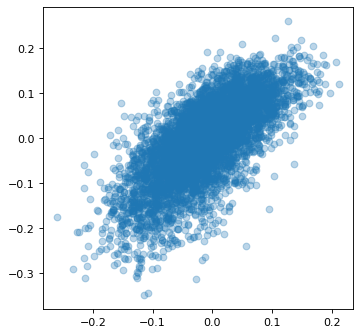

r2 = 0.503103
R2 = 0.497309
mse = 0.004179


In [213]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### Test on large data

In [18]:
class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(RBFGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        base_covar_module = ker


        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [19]:
ls = torch.tensor([[96.04]]).to(output_device)

In [20]:
inds_sub = np.where(np.array(pheno.pheno < -0.6) == False)[0]

np.random.seed(100)
sub = np.random.choice(inds_sub, 150000)
sub_t = np.random.choice(list(set(inds_sub).difference(sub)), 2000)

train_x = geno_t[sub]
train_y = torch.tensor(np.array(pheno.pheno[sub]), dtype=torch.float32)

test_x = geno_t[sub_t]
test_y = torch.tensor(np.array(pheno.pheno[sub_t]), dtype=torch.float32)

train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [21]:
ker = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()).to(output_device)
ker = gpytorch.kernels.RBFKernel().to(output_device)
ker.to(output_device)

RBFKernel(
  (raw_lengthscale_constraint): Positive()
)

In [22]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = RBFGPModel(train_x, train_y, likelihood, n_devices)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.AdamW(model.parameters(), .02)

In [23]:
model = model.to(output_device)

In [24]:
model.covar_module.module.lengthscale = ls

In [25]:
preconditioner_size = 100
checkpoint_size = train_x.shape[0]//8

test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
    f_preds = model(test_x)

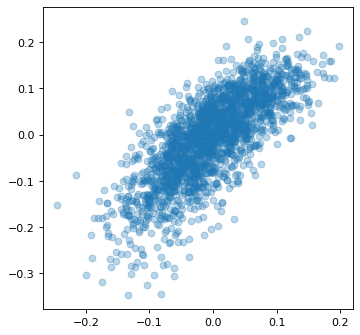

r2 = 0.579865
R2 = 0.576909
mse = 0.003687


In [26]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

### Test

#### Build RBF kernel from scratch

In [18]:
lda = torch.exp(torch.tensor(-8.))
eta = torch.exp(torch.tensor(-12.))

In [19]:
from gpytorch.constraints import Positive
from gpytorch.constraints import LessThan

class RBFKernel(Kernel):
    """Diploid kernel"""

    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, 
                **kwargs):
      super().__init__(**kwargs)

    # now set up the 'actual' paramter

    def forward(self, geno1, geno2, diag=False, **params):
        geno1_ht = 1.*(geno1 == 1.)
        geno2_ht = 1.*(geno2 == 1.)        
        geno1_h0 = 1.*(geno1 == 0.)
        geno1_h1 = 1.*(geno1 == 2.)
        geno2_h0 = 1.*(geno2 == 0.)
        geno2_h1 = 1.*(geno2 == 2.)

        S1 = self.covar_dist(geno1_ht, geno2_ht, **params)
        S2 = self.covar_dist(geno1_h0, geno2_h0, **params) + self.covar_dist(geno1_h1, geno2_h1, **params)
        D2 = self.covar_dist(geno1_h0, geno2_h1, **params) + self.covar_dist(geno1_h1, geno2_h0, **params)

#         res = torch.exp(-.01*S1)*torch.exp(-.05*S2)*torch.exp(-.02*D2)*torch.exp(-.001*(L - S1 - S2 - D2))
#         return res
        K = di_k(lda, eta, S1, S2, D2)
        if diag:
            return K.diag()
        else: return K

In [20]:
class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(RBFGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = RBFKernel()

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [18]:
class RBFGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(RBFGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.RBFKernel()

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [22]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = RBFGPModel(train_x, train_y, likelihood, n_devices)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.AdamW(model.parameters(), .02)

In [23]:
model = model.to(output_device)

In [26]:
checkpoint_size = train_x.shape[0]//8
with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
    output = model(train_x)
    loss = mll(output, train_y)
    loss.backward()
    optimizer.step()

In [27]:
preconditioner_size = 100
checkpoint_size = train_x.shape[0]//8
test_x = test_x.cuda()
model.eval()
likelihood.eval()

with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
    f_preds = model(test_x)

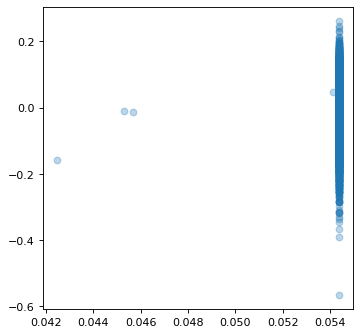

r2 = 0.000301
R2 = -0.423301
mse = 0.011706


In [28]:
f_mean = f_preds.mean.cpu().detach().numpy()
y_test = test_y.detach().cpu().numpy()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean, y_test, 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean, y_test)[0]**2)
print('R2 = %f'%r2(y_test, f_mean))
print('mse = %f'%mse(f_mean, y_test))

In [31]:
def train_model(model, 
                likelihood, 
                train_x, 
                train_y, 
                checkpoint_size, 
                preconditioner_size, 
                training_iter=300, 
                lr=.05):
    losses = []
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    for i in range(training_iter):
        print(i)
        with gpytorch.beta_features.checkpoint_kernel(checkpoint_size):
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()  
            losses.append(loss.item())
            optimizer.step()        

In [32]:
checkpoint_size = train_x.shape[0]//8
preconditioner_size = 100

In [33]:
losses = train_model(model, 
                likelihood, 
                train_x, 
                train_y, 
                checkpoint_size, 
                preconditioner_size, 
                training_iter=50, 
                lr=.1)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 37.25 GiB (GPU 0; 79.35 GiB total capacity; 44.32 GiB already allocated; 29.15 GiB free; 47.91 GiB reserved in total by PyTorch)

In [34]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 63% |
|  1 |  0% | 44% |
|  2 |  0% | 44% |
|  3 |  0% | 44% |
|  4 |  0% | 44% |
|  5 |  0% | 44% |
|  6 |  0% | 44% |
|  7 |  0% | 44% |
